<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

В данном проекте поможем магазину "Викишоп". Ему нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Алгоритм действий по выполнению проекта**

1. Загрузим и подготовьте и изучим данные.
2. Обучим разные модели, найдем лучшую и проверим на ней тестовую выборку. 
3. Сделаем выводы.

В этот раз проект выполним без системы BERT.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd
import spacy
import re
import tqdm
import nltk
import matplotlib.pyplot as plt
import time
import warnings


from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from joblib import dump, load
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')
display(data.head())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Данные успешно загрузились, у нас 4 столбца: 2 с индексом, 1 столбец с текстом, и 1 столбец с показателем токсичный комментарий или нет.  
Напишем функцию, чтобы узнать о базе данных больше.

In [4]:
def data_analysis(data):
    # проверка на наличие дубликатов
    if data.duplicated().sum() > 0:
        print("Количество дубликатов:", data.duplicated().sum())
    else:
        print("Дубликатов не найдено")
    
    # информация о типах данных и пропущенных значениях
    print("\nИнформация о типах данных и пропущенных значениях:")
    print(data.info())
    
    # статистические характеристики
    print("\nСтатистические характеристики:")
    print(data.describe())
    
    #Подсчёт уникальных значений в столбце
    print("\nКоличество уникальных значений в столбце 'Toxic'")
    print(data['toxic'].value_counts())
    
data_analysis(data)

Дубликатов не найдено

Информация о типах данных и пропущенных значениях:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None

Статистические характеристики:
          Unnamed: 0          toxic
count  159292.000000  159292.000000
mean    79725.697242       0.101612
std     46028.837471       0.302139
min         0.000000       0.000000
25%     39872.750000       0.000000
50%     79721.500000       0.000000
75%    119573.250000       0.000000
max    159450.000000       1.000000

Количество уникальных значений в столбце 'Toxic'
0    143106
1     16186
Name: toxic, dtype: int64


В нашем распоряжении 159292 комментариев, без дубликатов, комментарии записаны в формате object, а показатель токсичности в int64. Заметно, что токсичных комментариев, гораздо меньше, чем нетоксичных.

Посмотрим на эти значения на диаграмме.

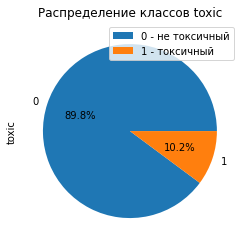

In [5]:
# построение круговой диаграммы
data['toxic'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Распределение классов toxic')
plt.legend(['0 - не токсичный', '1 - токсичный'])
plt.show()

Токсичных комментариев лишь 10.2% от общего количества в датасете. Учтём этот момент во время обучения моделей.
А пока подчистим текст от ненужных символов.

In [6]:
def clean_text(text):
   
    # удаление всех символов, кроме букв и пробелов
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)
    
    # приведение к нижнему регистру
    text = text.lower()
    
    return text

In [7]:
data['text'] = data['text'].apply(clean_text)

In [8]:
data.head(10)

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,daww he matches this background colour im seem...,0
2,2,hey man im really not trying to edit war its j...,0
3,3,more i cant make any real suggestions on impr...,0
4,4,you sir are my hero any chance you remember wh...,0
5,5,congratulations from me as well use the tools...,0
6,6,cocksucker before you piss around on my work,1
7,7,your vandalism to the matt shirvington article...,0
8,8,sorry if the word nonsense was offensive to yo...,0
9,9,alignment on this subject and which are contra...,0


Подчистили текст, удалили слэши и символы новой строки, привели комментарии к нижнему регистру, и, увидели один токсичный комментарий. :D

Приступим к лемматизации текста. Так как это процесс требующий время, лемматизированый текст будет сохранен и загружен в следующих ячейках.

In [9]:
nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

In [10]:
dump(data, 'toxic_lemmatized.csv')

['toxic_lemmatized.csv']

In [11]:
data = load('toxic_lemmatized.csv')

In [12]:
data.head(10)

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,daww he matches this background colour im seem...,0
2,2,hey man im really not trying to edit war its j...,0
3,3,more i cant make any real suggestions on impr...,0
4,4,you sir are my hero any chance you remember wh...,0
5,5,congratulations from me as well use the tools...,0
6,6,cocksucker before you piss around on my work,1
7,7,your vandalism to the matt shirvington article...,0
8,8,sorry if the word nonsense was offensive to yo...,0
9,9,alignment on this subject and which are contra...,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Текст прошел лемматизацию и успешно загрузился.

## Обучение

Разделим данные на обучающую и тестовую выборки в соотношении 80:20.

In [14]:
corpus = data['text'].values

features = corpus
target = data['toxic'].values

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=12345)

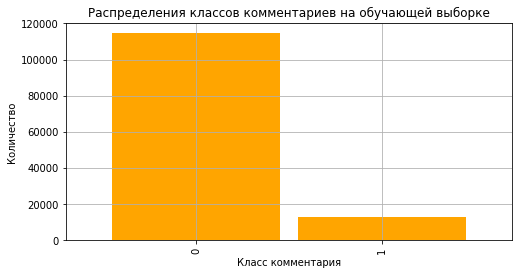

In [15]:
train_target_series = pd.Series(train_target)
train_target_series.value_counts().plot(
    kind='bar',
    stacked=True,
    grid=True,
    color='orange',
    width=0.9,
    figsize=(8,4)
)
plt.xlabel('Класс комментария')
plt.ylabel('Количество')
plt.title('Распределения классов комментариев на обучающей выборке')
plt.show()


Токсичных комментариев очень мало для обучения модели, необходимо обучить модель качественно, поэтому увеличим их количество, воспользуемся апсемплингом.

In [16]:
def upsample(features, target, repeat):
    features_zeros = pd.Series(features[target == 0])
    features_ones = pd.Series(features[target == 1])
    target_zeros = pd.Series(target[target == 0])
    target_ones = pd.Series(target[target == 1])
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    return shuffle(features_upsampled, target_upsampled, random_state=2023)


Увеличим количество токсичных комментариев в несколько раз.

In [17]:
train_features_upsampled, train_target_upsampled = upsample(train_features, train_target, 8)

<AxesSubplot:>

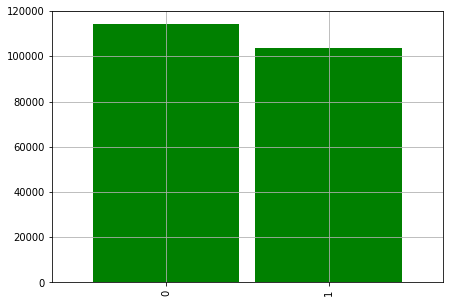

In [18]:
train_target_upsampled.value_counts().plot(
    kind='bar',
    stacked=True,
    grid=True,
    color='green',
    width=0.9,
    figsize=(7,5)
    )

После увеличения негативных комментариев примерно в восемь раз, графики выглядят почти одинаково.

Обучим несколько моделей на тренинговой выборке, проанализируем их, выберем лучшую и проверим на тестовой выборке.
Модели для анализа в данном проекте:
* LogisticRegression
* LinearSVC
* SGDClassifier
* DecisionTreeClassifier

In [19]:
# Запись оценок моделей
test_score = {}

В данной ячейки подбёрём лучшие параметры с помощью GridSearch.

In [20]:
lr_imba_pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=20000),
#    SMOTE(random_state=42),
    LogisticRegression(random_state=13, C=10, penalty='l2', class_weight='balanced', max_iter=500)
)

# Определение параметров StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Вычисление значения метрики F1 на кросс-валидации
start_time = time.time()
lr_cv_scores = cross_val_score(lr_imba_pipeline, train_features, train_target, cv=kf, scoring='f1')
end_time = time.time()

time_lr = end_time - start_time

print('Значение метрики F1 на кросс-валидации:', lr_cv_scores.mean())
print("Время обучения:", time_lr, 'сек.')

Значение метрики F1 на кросс-валидации: 0.7259766186336016
Время обучения: 382.3910768032074 сек.


In [21]:
test_score['LogisticRegression'] = [lr_cv_scores.mean(), time_lr]

In [22]:
svm_pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=20000),
    LinearSVC(random_state=42, dual=False, max_iter=5000, class_weight='balanced')
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()
svm_cv_scores = cross_val_score(svm_pipeline, train_features, train_target, cv=kf, scoring='f1')
end_time = time.time()

time_svm = end_time - start_time

print("Train F1-score:", svm_cv_scores.max())
print("Время обучения:", time_svm, "сек.")

Train F1-score: 0.7210930828351836
Время обучения: 174.26750254631042 сек.


In [23]:
test_score['LinearSVC'] = [svm_cv_scores, time_svm]

In [24]:
sgd_imba_pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.5, min_df=2, sublinear_tf=True),
    SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-5, random_state=42, max_iter=5000, tol=1e-3, class_weight='balanced')
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()
sgd_cv_scores = cross_val_score(sgd_imba_pipeline, train_features, train_target, cv=kf, scoring='f1')
end_time = time.time()

time_sgd = end_time - start_time

print("Train F1-score:", sgd_cv_scores.max())
print("Время обучения:", time_sgd, "сек.")

Train F1-score: 0.7606685633001423
Время обучения: 60.35671305656433 сек.


In [25]:
test_score['SGDClassifier'] = [sgd_cv_scores, time_sgd]

In [26]:
tree_imba_pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=20000),
    SMOTE(random_state=42),
    DecisionTreeClassifier(random_state=13, max_depth=15, class_weight='balanced', min_samples_leaf=10)
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()
tree_cv_scores = cross_val_score(tree_imba_pipeline, train_features, train_target, cv=kf, scoring='f1')
end_time = time.time()
time_tree = end_time - start_time

print('Значение метрики F1 на кросс-валидации:', tree_cv_scores.max())
print("Время обучения:", time_tree, "сек.")

Значение метрики F1 на кросс-валидации: 0.600825042465421
Время обучения: 353.96607756614685 сек.


In [27]:
test_score['DecisionTreeClassifier'] = [tree_cv_scores, time_tree]

In [28]:
data_score = pd.DataFrame.from_dict(data=test_score, columns=['F1 Score','Время обучения'], orient='index')
display(data_score)

,F1 Score,Время обучения
LogisticRegression,0.725977,382.391077
LinearSVC,"[0.710637578217487, 0.714236940935473, 0.71387...",174.267503
SGDClassifier,"[0.7481789802289283, 0.7533865925668635, 0.753...",60.356713
DecisionTreeClassifier,"[0.5816532258064516, 0.5903018307768432, 0.598...",353.966078


В данной главе мы изучили 4 модели на тренинговой выборке. Из них лишь 2 показывают высокие результаты **LinearSVC** и **SGDClassifier**. Модели **DecisionTreeClassifier** и **LogisticRegression** обучается крайне медленно, а также показывают низкие результаты. Самый лучший результат в соотношении "F1-Время", показывает модель **SGDClassifier**, именно к ней подберем разные гиперпараметры, и посмотрим на результат на тестовой выборке.

In [29]:
best_model = make_pipeline(
    TfidfVectorizer(stop_words='english', ngram_range=(1, 2)),
    SGDClassifier(penalty='l2', alpha=1e-5, random_state=42, max_iter=1000, tol=1e-3, class_weight='balanced')
)


start_time = time.time()

best_model.fit(train_features, train_target)

end_time = time.time()

# Предсказываем значения на тестовых данных
test_predictions = best_model.predict(test_features)

# Оцениваем качество модели

f1 = f1_score(test_target, test_predictions)
time_best = end_time - start_time
print("F1-score:", f1)
print("Время обучения:", time_best, "сек.")

F1-score: 0.7906131718395156
Время обучения: 18.805829286575317 сек.


На тестовых данных модель выполняет задачу и показывает требуемую метрику - **F1 = 0.7906**.

## Выводы

* Мы провели анализ данных и лемматизировали текст для построения модели, которая будет выявлять токсичные комментарии пользователей в магазине "Викишоп".
* Для обучения моделей мы использовали библиотеки imblearn.pipeline и StratifiedKFold, которые помогли сохранить баланс классов, а также специальные алгоритмы, которые учитывают дисбаланс классов, например, параметр class_weight='balanced'.
* Мы проверили несколько моделей и выбрали SGDClassifier, которая показала лучший результат метрики F1 на кросс-валидационных данных и на тестовой выборке.
* Модель показала F1 = 0.7906 на тестовой выборке, что означает, что она корректно определяет примерно 79% токсичных комментариев.
* Рекомендуется использовать данную модель для выявления токсичных комментариев в магазине "Викишоп".